# Deep Learning 3rd Assignment - Part a

In this section you should implement Adam algorithm with numpy on the following objective function:
\begin{equation}
x^2 + y^2
\end{equation}
Try and analyze the performance of this algorithm with different values for beta1 and beta2.

In [ ]:
### Write Your Code Here ###
import numpy as np
def objective_function(x, y):
  return x**2 + y**2

def compute_gradient(x, y):
  return np.array([2.0 * x, 2.0 * y])

def adam(learning_rate, number_of_iterations, beta1, beta2, var_limit):
  var = var_limit[:, 0] + np.random.rand(len(var_limit)) * (var_limit[:, 1] - var_limit[:, 0])
  objective_value = objective_function(var[0], var[1])
  first_moment = [0 for el in range(var_limit.shape[0])]
  second_moment = [0 for el in range(var_limit.shape[0])]

  for t in range(1, number_of_iterations):
    grad = compute_gradient(var[0], var[1])
    for i in range(var.shape[0]):
      first_moment[i] = beta1 * first_moment[i] + (1 - beta1) * grad[i]
      second_moment[i] = beta2 * second_moment[i] + (1 - beta2) * grad[i] * grad[i]

      first_unbias = first_moment[i] / (1.0 - beta1 ** t)
      second_unbias = second_moment[i] / (1.0 - beta2 ** t)

      var[i] -= learning_rate * first_unbias / (np.sqrt(second_unbias) + 1e-7)
    objective_value = objective_function(var[0], var[1])
      
      

  return var, objective_value

learning_rate = 1e-1
number_of_iterations = 100
beta1 = 0.1
beta2 = 0.999
var_limit = np.array([[-1, 1], [-1, 1]])
adam(learning_rate, number_of_iterations, beta1, beta2, var_limit)


(array([-1.09655876e-22,  3.86495570e-43]), 1.2024411173779359e-44)

Please write your observations and conclusion of running the algorithm with different values for beta1 and beta2.

<font color='red'>if beta2 is less than and almost equal to 1 the result is better and if beta2 is almost equal to zero the result gets worse and about beta1 usually if beta1 is greater than but almost equal to 0 the result is better and as betal goes up the result gets worse.</font>

# Deep Learning 3rd Assignment - Part b

---

In this assignment we will be focusing on optimizing neural networks. As you may already know Keras API has a lot of built-in functions for optimization that you can use. However you may want to impelement your own custom optimization function or design one for your specific problem.

The purpose of this notebook is to teach you to implement your own optimization function by using Keras API.


In [ ]:
#@title Import necessary modules

import tensorflow as tf
from tensorflow import keras

from keras.optimizers import Optimizer
from keras import backend as K

from keras.datasets import mnist
import matplotlib.pyplot as plt

import numpy as np
import os

To keep things rather simple and draw our full attention towards implementing custom optimization functions, we use a simple classification problem. The first step is to prepare our data.

## Data Preparation

Run the code below to load and plot the handwritten digit recognition dataset.

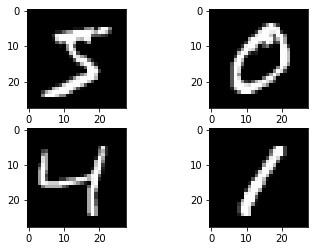

In [ ]:
# Load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))

plt.show()

Since we have not yet studied Convolutional Neural Networks (AKA CNN), we would like to solve this problem by using Multi-Layer Perceptrons. 

Note that our data is two-dimensional and since we are not using CNNs, we should reshape our data to make it compatible for MLPs. In the following code cell convert the input shape to a vector of pixels.

In [ ]:
# Reshape the test and training datasets 

X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

# Normalizing data

X_train = X_train / 255
X_test = X_test / 255

Now since our problem is a multi-class classification problem we should label our data from 0 to 9 (there are 10 handwritten digits). We can simply do this using keras's built-in to_categorical() function.

In [ ]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print(num_classes)

10


## Defining Our Custom Optimizer

This is the main part of this assignment because you are going to implement your custom optimizer. 

Below you should implement the SGD algorithm that you have learned in class. The class inherits from the Optimizer class in Keras. So all you need to do is to overwrite the functions specified below to have your own custom optimizer. 

In the constructor section you should define your hyperparameters and in resource_apply_dence function you write your main algorithm for optimizing.

You can visit [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer) to get further information on how to implement your own optimizer in tensorflow.

In [ ]:
class CustomSGD(Optimizer):
    def __init__(self, learning_rate=0.01, name="CustomSGD", **kwargs):
        """you can set and store your hyper-parameters here"""
        super().__init__(name, **kwargs)
        """Define learning rate hyper param here"""
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        # self._is_first = True


    @tf.function
    def _resource_apply_dense(self, grad, var):
        """ This is where you implement SGD algorithm with decayed learning rate """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay

        new_var = var - grad * lr_t
        var.assign(new_var)
    def _resource_apply_sparse(self, grad, var):
        """ No need to do anything here """
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
        }

## Creating Our Model

In this section we will create our model. You only need dense layers and don't forget to use your custom SGD. Also try changing the learning rate of the optimizer and analyze the effect of the learning rate on your model's performance.

In [ ]:
def mlp_model():
    # create model here
    model = tf.keras.Sequential()
    # model.add(tf.keras.layers.Dense(units=32, activation='relu'))
    # model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
    
    # Compile model here 
    optimizer = CustomSGD(learning_rate=0.5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

Now run the following code cell to train and evaluate our model.

In [ ]:
model = mlp_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Model Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
300/300 - 2s - loss: 0.3520 - accuracy: 0.8937 - val_loss: 0.1823 - val_accuracy: 0.9472
Epoch 2/10
300/300 - 1s - loss: 0.1551 - accuracy: 0.9553 - val_loss: 0.1293 - val_accuracy: 0.9613
Epoch 3/10
300/300 - 1s - loss: 0.1141 - accuracy: 0.9670 - val_loss: 0.1013 - val_accuracy: 0.9703
Epoch 4/10
300/300 - 1s - loss: 0.0907 - accuracy: 0.9738 - val_loss: 0.0961 - val_accuracy: 0.9705
Epoch 5/10
300/300 - 1s - loss: 0.0755 - accuracy: 0.9780 - val_loss: 0.0860 - val_accuracy: 0.9731
Epoch 6/10
300/300 - 1s - loss: 0.0632 - accuracy: 0.9822 - val_loss: 0.0863 - val_accuracy: 0.9729
Epoch 7/10
300/300 - 1s - loss: 0.0549 - accuracy: 0.9842 - val_loss: 0.0831 - val_accuracy: 0.9738
Epoch 8/10
300/300 - 1s - loss: 0.0485 - accuracy: 0.9860 - val_loss: 0.0752 - val_accuracy: 0.9748
Epoch 9/10
300/300 - 1s - loss: 0.0420 - accuracy: 0.9880 - val_loss: 0.0683 - val_accuracy: 0.9783
Epoch 10/10
300/300 - 1s - loss: 0.0369 - accuracy: 0.9898 - val_loss: 0.0707 - val_accuracy: 0.9769